In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')
house_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0)]

In [2]:
house_df.cache()
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PT: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MV: double (nullable = true)



In [3]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235608162057,8.601545086715594,0.00632,88.97619629
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778749531626,6.86035298095724,0.460000008,27.73999977
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950602312246,0.1158776754570543,0.38499999,0.870999992
RM,506,6.28463438896641,0.7026171549511354,3.561000109,8.779999733
AGE,506,68.57490120115612,28.148861532793276,2.900000095,100.0
DIS,506,3.7950426960059325,2.105710142043288,1.129600048,12.12650013
RAD,506,9.549407114624506,8.707259384239366,1,24


In [10]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MV',i))

Correlation to MV for  CRIM -0.3883046116575088
Correlation to MV for  ZN 0.36044534463752903
Correlation to MV for  INDUS -0.48372517128143383
Correlation to MV for  CHAS 0.17526017775291847
Correlation to MV for  NOX -0.4273207763683772
Correlation to MV for  RM 0.695359937127267
Correlation to MV for  AGE -0.37695456714288667
Correlation to MV for  DIS 0.24992873873512172
Correlation to MV for  RAD -0.3816262315669168
Correlation to MV for  TAX -0.46853593528654536
Correlation to MV for  PT -0.5077867038116085
Correlation to MV for  B 0.3334608226834164
Correlation to MV for  LSTAT -0.7376627294671615
Correlation to MV for  MV 1.0


In [11]:
house_df.dtypes

[('CRIM', 'double'),
 ('ZN', 'double'),
 ('INDUS', 'double'),
 ('CHAS', 'int'),
 ('NOX', 'double'),
 ('RM', 'double'),
 ('AGE', 'double'),
 ('DIS', 'double'),
 ('RAD', 'int'),
 ('TAX', 'int'),
 ('PT', 'double'),
 ('B', 'double'),
 ('LSTAT', 'double'),
 ('MV', 'double')]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead


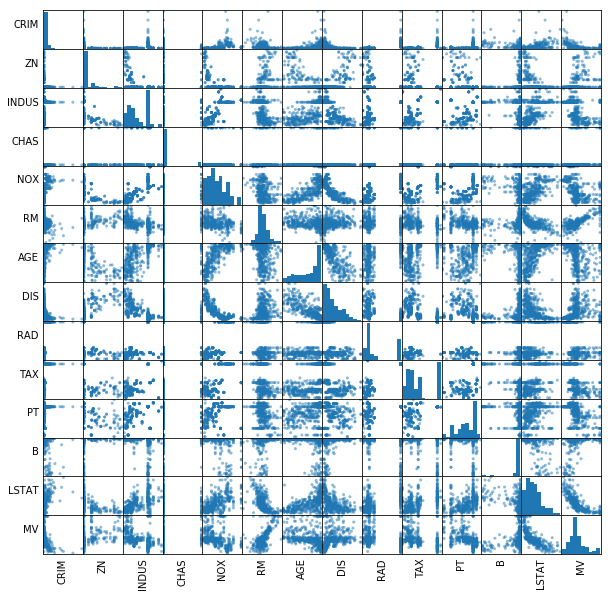

In [12]:
import pandas as pd

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [13]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]))]

In [14]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression

In [28]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.007372337189510928,0.004014175396923658,0.0,1.2936430183580436,-4.143328082596611,4.706244251698328,-0.0049141723159337805,-0.4661648332081315,0.0,-0.0009883852534814028,-0.8534799709955787,0.009562664429664629,-0.44665346837827274]
Intercept: 15.470760825151896


#### Summarize the model over the training set and print out some metrics

In [29]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.709834
r2: 0.726530


In [41]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MV","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
lr_evaluator.evaluate(lr_predictions)

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|30.253150509010133|35.40000153|[0.01311,90.0,1.2...|
|38.215822226340926|       50.0|[0.01381,80.0,0.4...|
| 31.01948794253173|31.60000038|[0.01432,100.0,1....|
| 34.65191515852811|       44.0|[0.01538,90.0,3.7...|
|26.938942422323333|30.10000038|[0.01709,90.0,2.0...|
+------------------+-----------+--------------------+
only showing top 5 rows



0.659300917109979

In [34]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.4324748180993134, 0.22835248178391437, 0.20443246155915093, 0.1752660506336422, 0.1735064500251287, 0.17271054925063, 0.17264707342703475, 0.1721629866384196, 0.172074842834375, 0.17181300503345032]
+-------------------+
|          residuals|
+-------------------+
| -6.250677146644541|
| 1.2477131801586197|
| -5.629788889515382|
| 0.5523677765556769|
| 2.0498057689987235|
| -1.108026094860083|
|-2.9568044395963042|
|   9.54581291743014|
| 1.9939518193897534|
|  10.92392222791213|
| -1.138297024349086|
|  5.901516585622105|
|-10.266459818997092|
| -3.551231068004764|
| 3.4486849948809812|
|-3.7247934654055896|
|-1.2560437264602484|
|0.40530046755307936|
| 2.7181259128929405|
|  2.051358960216085|
+-------------------+
only showing top 20 rows



In [35]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MV","features").show()

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|30.253150509010133|35.40000153|[0.01311,90.0,1.2...|
|38.215822226340926|       50.0|[0.01381,80.0,0.4...|
| 31.01948794253173|31.60000038|[0.01432,100.0,1....|
| 34.65191515852811|       44.0|[0.01538,90.0,3.7...|
|26.938942422323333|30.10000038|[0.01709,90.0,2.0...|
|25.872993176242765|23.10000038|[0.0187,85.0,4.15...|
|26.734843348889825|       33.0|[0.019509999,17.5...|
|20.844448434408353|20.10000038|[0.019649999,80.0...|
|31.043216455974633|31.10000038|[0.02187,60.0,2.9...|
|28.397001805091723|30.79999924|[0.027629999,75.0...|
| 19.76671275529597|       18.5|[0.030409999,0.0,...|
|24.212335077594386|19.39999962|[0.03466,35.0,6.0...|
|  23.9694308073066|22.89999962|[0.03551,25.0,4.8...|
| 37.10701938812308|45.40000153|[0.035780001,20.0...|
|27.858082822660172|27.89999962|[0.036150001,80.0...|
| 23.08029401498007|20.70000

### Decision tree regression

In [36]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MV')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.33905


### Gradient-boosted tree regression

In [37]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MV', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'MV', 'features').show(5)

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
| 36.82407348623249|35.40000153|[0.01311,90.0,1.2...|
| 49.92616622728028|       50.0|[0.01381,80.0,0.4...|
|27.526736203791444|31.60000038|[0.01432,100.0,1....|
|36.688235916615994|       44.0|[0.01538,90.0,3.7...|
|27.245950411314638|30.10000038|[0.01709,90.0,2.0...|
+------------------+-----------+--------------------+
only showing top 5 rows



In [38]:
gbt_evaluator = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.12108
